In [94]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy import stats
import numpy as np
import math
import pingouin as pg
import statsmodels.formula.api as smf
from datetime import datetime



# 18th of july 2025 - the sessions that are currently available are in loaded_sessions
print(loaded_sessions)
session_list = ['s02', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 's11', 's12', 's13', 's14', 's15', 's18', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's41', 's43', 's44', 's45', 's46', 's48', 's49', 's52', 's54', 's55']

In [ ]:
# find out what's going on with the ripples in s31 to s38, and in s45&46
#print(ripple_rates_df[ripple_rates_df['session'].isin(['s31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's45', 's46'])])
print(ripple_rates_df[ripple_rates_df['session'].isin(['s31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's45', 's46'])])
# looks like these are empty!!
sesh = 's31'
ripple_path = f"{result_path}/{sesh}/LFP-ripples/ripples_{sesh}.csv"
rips = pd.read_csv(ripple_path)
rips.head()

# check whats going on here! Suspicion: no hippocampal channels?

     session grid_no    phase  ripple_count  duration  ripple_rate
1470     s31       1  explore             0     63.33          0.0
1471     s31       1     plan             0     26.16          0.0
1472     s31       1   repeat             0     64.83          0.0
1473     s31       2  explore             0     24.86          0.0
1474     s31       2     plan             0     15.30          0.0
...      ...     ...      ...           ...       ...          ...
2407     s46      23     plan             0      5.50          0.0
2408     s46      23   repeat             0     42.00          0.0
2409     s46      24  explore             0     23.30          0.0
2410     s46      24     plan             0      5.80          0.0
2411     s46      24   repeat             0     39.60          0.0

[720 rows x 6 columns]


,onset_in_secs,onset_in_samples,duration,channel,grid_no,task,snippet


In [ ]:
# also the result table from the previous step is empty.
# actually, there are loads of channels in the hippocampus, but there seems to have been a problem with the preprocessing!
channel_path = f"{result_path}/{sesh}/LFP/channels.npy"
channels_s31 = np.load(channel_path)
print(channels_s31)

['LT2aA01-001' 'LT2aA02-002' 'LT2aA03-003' 'LT2aA04-004' 'LT2aA05-005'
 'LT2aA06-006' 'LT2aA07-007' 'LT2aA08-008' 'LT2aA09-009' 'LT2aA10-010'
 'LT2aA11-011' 'LT2aA12-012' 'LT2aA13-013' 'LT2aA14-014' 'LT2bHaE01-015'
 'LT2bHaE02-016' 'LT2bHaE03-017' 'LT2bHaE04-018' 'LT2bHaE05-019'
 'LT2bHaE06-020' 'LT2bHaE07-021' 'LT2bHaE08-022' 'LT2bHaE09-023'
 'LT2cHb01-024' 'LT2cHb02-025' 'LT2cHb03-026' 'LT2cHb04-027'
 'LT2cHb05-028' 'LT2cHb06-029' 'LT2cHb07-030' 'LT2cHb08-031'
 'LT2cHb09-032' 'LT1cPulv01-033' 'LT1cPulv02-034' 'LT1cPulv03-035'
 'LT1cPulv04-036' 'LT1cPulv05-037' 'LT1cPulv06-038' 'LT1cPulv07-039'
 'LT1cPulv08-040' 'LT1cPulv09-041' 'LT1cPulv10-042' 'LT1cPulv11-043'
 'LT1cPulv12-044' 'LT1cPulv13-045' 'LT1cPulv14-046' 'LT1cPulv15-047'
 'LT1cPulv16-048' 'LF3C01-049' 'LF3C02-050' 'LF3C03-051' 'LF3C04-052'
 'LF3C05-053' 'LF3C06-054' 'LF3C07-055' 'LF3C08-056' 'LF3C09-057'
 'RT2aHaE01-058' 'RT2aHaE02-059' 'RT2aHaE03-060' 'RT2aHaE04-061'
 'RT2aHaE05-062' 'RT2aHaE06-063' 'RT2aHaE07-064' 'RT1cCM01

AttributeError: 'dict' object has no attribute 'head'

In [66]:
# Session list
session_list = list(range(60))
result_path = "/Users/xpsy1114/Documents/projects/multiple_clocks/data/ephys_humans/derivatives"

# Check if on server
if not os.path.isdir(result_path):
    print("running on ceph")
    result_path = "/ceph/behrens/svenja/human_ABCD_ephys/derivatives"

# Data containers
power_dict = {}
ripple_events = {}
beh = {}
loaded_sessions = []

column_names = [
    'rep_correct', 't_A', 't_B', 't_C', 't_D',
    'loc_A', 'loc_B', 'loc_C', 'loc_D',
    'rep_overall', 'new_grid_onset', 'session_no', 'grid_no'
]

# Loop through sessions and only load those with all files present
for s_idx in session_list:
    sesh = f"s{s_idx:02}"

    power_path = f"{result_path}/{sesh}/LFP-ripples/ripple_power_dict_{sesh}"
    beh_path = f"{result_path}/{sesh}/cells_and_beh/all_trial_times_{s_idx:02}.csv"
    ripple_path = f"{result_path}/{sesh}/LFP-ripples/ripples_{sesh}.csv"

    if os.path.isfile(power_path) and os.path.isfile(beh_path) and os.path.isfile(ripple_path):
        # Load power
        with open(power_path, 'rb') as f:
            power_dict[sesh] = pickle.load(f)
        # Load behavior
        beh[sesh] = pd.read_csv(beh_path, header=None)
        beh[sesh].columns = column_names
        # Load ripple events
        ripple_events[sesh] = pd.read_csv(ripple_path)

        loaded_sessions.append(sesh)
    else:
        print(f"Missing files for {sesh}, skipping.")

# ✅ Summary
print(f"\nLoaded sessions ({len(loaded_sessions)}): {loaded_sessions}")

    

running on ceph
Missing files for s00, skipping.
Missing files for s01, skipping.
Missing files for s03, skipping.
Missing files for s16, skipping.
Missing files for s17, skipping.
Missing files for s19, skipping.
Missing files for s20, skipping.
Missing files for s21, skipping.
Missing files for s22, skipping.
Missing files for s30, skipping.
Missing files for s39, skipping.
Missing files for s40, skipping.
Missing files for s42, skipping.
Missing files for s47, skipping.
Missing files for s50, skipping.
Missing files for s51, skipping.
Missing files for s53, skipping.
Missing files for s56, skipping.
Missing files for s57, skipping.
Missing files for s58, skipping.
Missing files for s59, skipping.

Loaded sessions (39): ['s02', 's04', 's05', 's06', 's07', 's08', 's09', 's10', 's11', 's12', 's13', 's14', 's15', 's18', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's41', 's43', 's44', 's45', 's46', 's48', 's49', 's52', 's54', '

In [67]:
sesh = loaded_sessions[-1]
print(f"overview of ripple event table for sessions {sesh}")
print(len(ripple_events[sesh]))
ripple_events[sesh].sort_values('onset_in_secs').head()

overview of ripple event table for sessions s55
163


,onset_in_secs,onset_in_samples,duration,channel,grid_no,task,snippet
86,217.672,466,0.024,bRAHIP1,grid1,8267,216.74-228.64sec
97,241.690,6525,0.026,mRAHIP1,grid1,8267,228.64-258.96sec
50,261.112,1076,0.024,mRAHIP1,grid1,8267,258.96-268.84sec
158,278.032,356,0.020,RPHIP1,grid1,8267,277.32-284.30sec
89,337.692,6566,0.028,bRAHIP1,grid1,8267,324.56-338.80sec


In [68]:
sesh = loaded_sessions[-1]
print(f"overview of behavioural table for sessions {sesh}")
print(len(beh[sesh]))
beh[sesh].head()

overview of behavioural table for sessions s55
390


,rep_correct,t_A,t_B,t_C,t_D,loc_A,loc_B,loc_C,loc_D,rep_overall,new_grid_onset,session_no,grid_no
0,0,165.85,175.99,188.45,197.02,8,2,6,7,1,141.08,1,1
1,0,206.59,208.71,214.80,216.74,8,2,6,7,2,197.02,1,1
2,0,220.06,223.12,226.43,228.64,8,2,6,7,3,216.74,1,1
3,1,232.74,241.31,256.12,258.96,8,2,6,7,4,228.64,1,1
4,1,261.56,265.40,267.34,268.84,8,2,6,7,5,258.96,1,1


In [69]:
print(f"overview of power dictionary structure {sesh}")
print()
def print_dict_structure(d, indent=0):
    prefix = "  " * indent
    if isinstance(d, dict):
        for key, value in d.items():
            if isinstance(value, dict):
                print(f"{prefix}{key}/ (dict)")
                print_dict_structure(value, indent + 1)
            elif isinstance(value, list):
                print(f"{prefix}{key} - list of length {len(value)}")
                if value and isinstance(value[0], dict):
                    print(f"{prefix}  [0]/ (dict in list)")
                    print_dict_structure(value[0], indent + 2)
            else:
                print(f"{prefix}{key} - {type(value).__name__}")
    else:
        print(f"{prefix}- {type(d).__name__}: {d}")

print_dict_structure(power_dict[sesh])

overview of power dictionary structure s55

1037.80-1048.00sec_grid4_ABCD_3795_500_Hz/ (dict)
  LFP_mean_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
  LFP_stepwise_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
4152.10-4158.40sec_grid17_ABCD_8267_500_Hz/ (dict)
  LFP_mean_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
  LFP_stepwise_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
513.04-522.89sec_grid2_ABCD_7342_500_Hz/ (dict)
  LFP_mean_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_gamma - ndarray
  LFP_stepwise_power/ (dict)
    theta - ndarray
    SW - ndarray
    middle - ndarray
    hgamma - ndarray
    ultra_high_g

In [70]:
# sort timings in 'plan', 'explore' and 'repeat' for each grid.
beh_phases = {}
for sesh in beh:
    phases = []

    for grid_id, group in beh[sesh].groupby("grid_no"):
        group = group.sort_values(by="rep_overall")  # Ensure order

        # Find 'explore' phase
        first_row = group[group['rep_correct'] == 0].iloc[0]
        explore_start = first_row['new_grid_onset']
        explore_end = first_row['t_D']

        # Find 'plan' phase
        last_plan_row = group[group['rep_correct'] == 0].iloc[-1]
        plan_start = explore_end
        plan_end = last_plan_row['t_D']

        # Find 'repeat' phase
        max_rep_row = group.loc[group['rep_overall'].idxmax()]
        repeat_start = plan_end
        repeat_end = max_rep_row['t_D']

        # Add to list
        phases.append({
            'grid_no': grid_id,
            'phase': 'explore',
            'start': explore_start,
            'end': explore_end
        })
        phases.append({
            'grid_no': grid_id,
            'phase': 'plan',
            'start': plan_start,
            'end': plan_end
        })
        phases.append({
            'grid_no': grid_id,
            'phase': 'repeat',
            'start': repeat_start,
            'end': repeat_end
        })
    
    # Create result DataFrame
    beh_phases[sesh] = pd.DataFrame(phases)
    beh_phases[sesh]['duration'] = beh_phases[sesh]['end'] - beh_phases[sesh]['start']

beh_phases[sesh].head()

,grid_no,phase,start,end,duration
0,1,explore,141.08,197.02,55.94
1,1,plan,197.02,228.64,31.62
2,1,repeat,228.64,348.00,119.36
3,2,explore,370.27,409.85,39.58
4,2,plan,409.85,428.65,18.80


In [71]:
#compute the ripple rate per grid. 
ripple_rates = {}
for sesh in beh: 
    # Ensure grid numbers are consistently typed
    beh_phases[sesh]['grid_no'] = beh_phases[sesh]['grid_no'].astype(str)
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].str.extract(r'(\d+)')  # Extract numeric part from 'grid1'
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].astype(str)

    # Prepare an empty list to collect results
    results = []

    # Loop through each phase
    for _, phase_row in beh_phases[sesh].iterrows():
        grid = phase_row['grid_no']
        phase = phase_row['phase']
        start = phase_row['start']
        end = phase_row['end']
        duration = phase_row['duration']

        # Get matching ripples
        ripples_in_phase = ripple_events[sesh][
            (ripple_events[sesh]['grid_no'] == grid) &
            (ripple_events[sesh]['onset_in_secs'] >= start) &
            (ripple_events[sesh]['onset_in_secs'] < end)
        ]

        # Calculate ripple rate
        ripple_count = len(ripples_in_phase)
        ripple_rate = ripple_count / duration if duration > 0 else 0

        results.append({
            'grid_no': grid,
            'phase': phase,
            'ripple_count': ripple_count,
            'duration': duration,
            'ripple_rate': ripple_rate
        })
    
    ripple_rates[sesh]= pd.DataFrame(results)
ripple_rates[sesh].head()

,grid_no,phase,ripple_count,duration,ripple_rate
0,1,explore,0,55.94,0.000000
1,1,plan,1,31.62,0.031626
2,1,repeat,4,119.36,0.033512
3,2,explore,1,39.58,0.025265
4,2,plan,0,18.80,0.000000


In [72]:
all_results = []  # Collect all per-session dataframes here

for sesh in beh:
    # Ensure grid numbers are consistently typed
    beh_phases[sesh]['grid_no'] = beh_phases[sesh]['grid_no'].astype(str)
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].str.extract(r'(\d+)')
    ripple_events[sesh]['grid_no'] = ripple_events[sesh]['grid_no'].astype(str)

    results = []

    for _, phase_row in beh_phases[sesh].iterrows():
        grid = phase_row['grid_no']
        phase = phase_row['phase']
        start = phase_row['start']
        end = phase_row['end']
        duration = phase_row['duration']

        ripples_in_phase = ripple_events[sesh][
            (ripple_events[sesh]['grid_no'] == grid) &
            (ripple_events[sesh]['onset_in_secs'] >= start) &
            (ripple_events[sesh]['onset_in_secs'] < end)
        ]

        ripple_count = len(ripples_in_phase)
        rate = ripple_count / duration if duration > 0 else 0

        results.append({
            'session': sesh,
            'grid_no': grid,
            'phase': phase,
            'ripple_count': ripple_count,
            'duration': duration,
            'ripple_rate': rate
        })

    all_results.append(pd.DataFrame(results))

# Combine all into a single DataFrame
ripple_rates_df = pd.concat(all_results, ignore_index=True)
ripple_rates_df.head()

,session,grid_no,phase,ripple_count,duration,ripple_rate
0,s02,1,explore,1,58.55,0.017079
1,s02,1,plan,0,9.77,0.000000
2,s02,1,repeat,0,56.08,0.000000
3,s02,2,explore,1,28.35,0.035273
4,s02,2,plan,1,11.60,0.086207


In [73]:
# compute stats per session.
# Store session-level stats
session_stats = []

for sesh, group in ripple_rates_df.groupby('session'):
    summary = group.groupby('phase')['ripple_rate'].agg(['mean', 'sem']).reset_index()
    summary['session'] = sesh

    # Pairwise t-tests between phases
    def get_rates(phase): return group[group['phase'] == phase]['ripple_rate']
    try:
        t_explore_plan = stats.ttest_rel(get_rates('explore'), get_rates('plan'))
        t_plan_repeat = stats.ttest_rel(get_rates('plan'), get_rates('repeat'))
        t_explore_repeat = stats.ttest_rel(get_rates('explore'), get_rates('repeat'))
    except Exception as e:
        print(f"Error in t-tests for session {sesh}: {e}")
        t_explore_plan = t_plan_repeat = t_explore_repeat = [np.nan, np.nan]

    session_stats.append({
        'session': sesh,
        'means': summary.set_index('phase')['mean'].to_dict(),
        'sems': summary.set_index('phase')['sem'].to_dict(),
        't_explore_vs_plan_p': t_explore_plan.pvalue,
        't_plan_vs_repeat_p': t_plan_repeat.pvalue,
        't_explore_vs_repeat_p': t_explore_repeat.pvalue
    })
    
stats_df = pd.DataFrame(session_stats)
stats_df.head()


,session,means,sems,t_explore_vs_plan_p,t_plan_vs_repeat_p,t_explore_vs_repeat_p
0,s02,"{'explore': 0.011778148604280203, 'plan': 0.01...","{'explore': 0.0038281766745439936, 'plan': 0.0...",0.978316,0.191396,0.026369
1,s04,"{'explore': 0.010363054850144474, 'plan': 0.03...","{'explore': 0.005032968132853272, 'plan': 0.02...",0.328720,0.273966,0.713953
2,s05,"{'explore': 0.09207278849678052, 'plan': 0.064...","{'explore': 0.01390569370993894, 'plan': 0.009...",0.125736,0.034659,0.574895
3,s06,"{'explore': 0.016448183329265547, 'plan': 0.00...","{'explore': 0.005431668587530186, 'plan': 0.00...",0.055136,0.381418,0.363114
4,s07,"{'explore': 0.00797264661136554, 'plan': 0.004...","{'explore': 0.002927742921039167, 'plan': 0.00...",0.352736,0.269903,0.805271


In [74]:
# Utility: turn p-value into stars
def p_to_star(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'

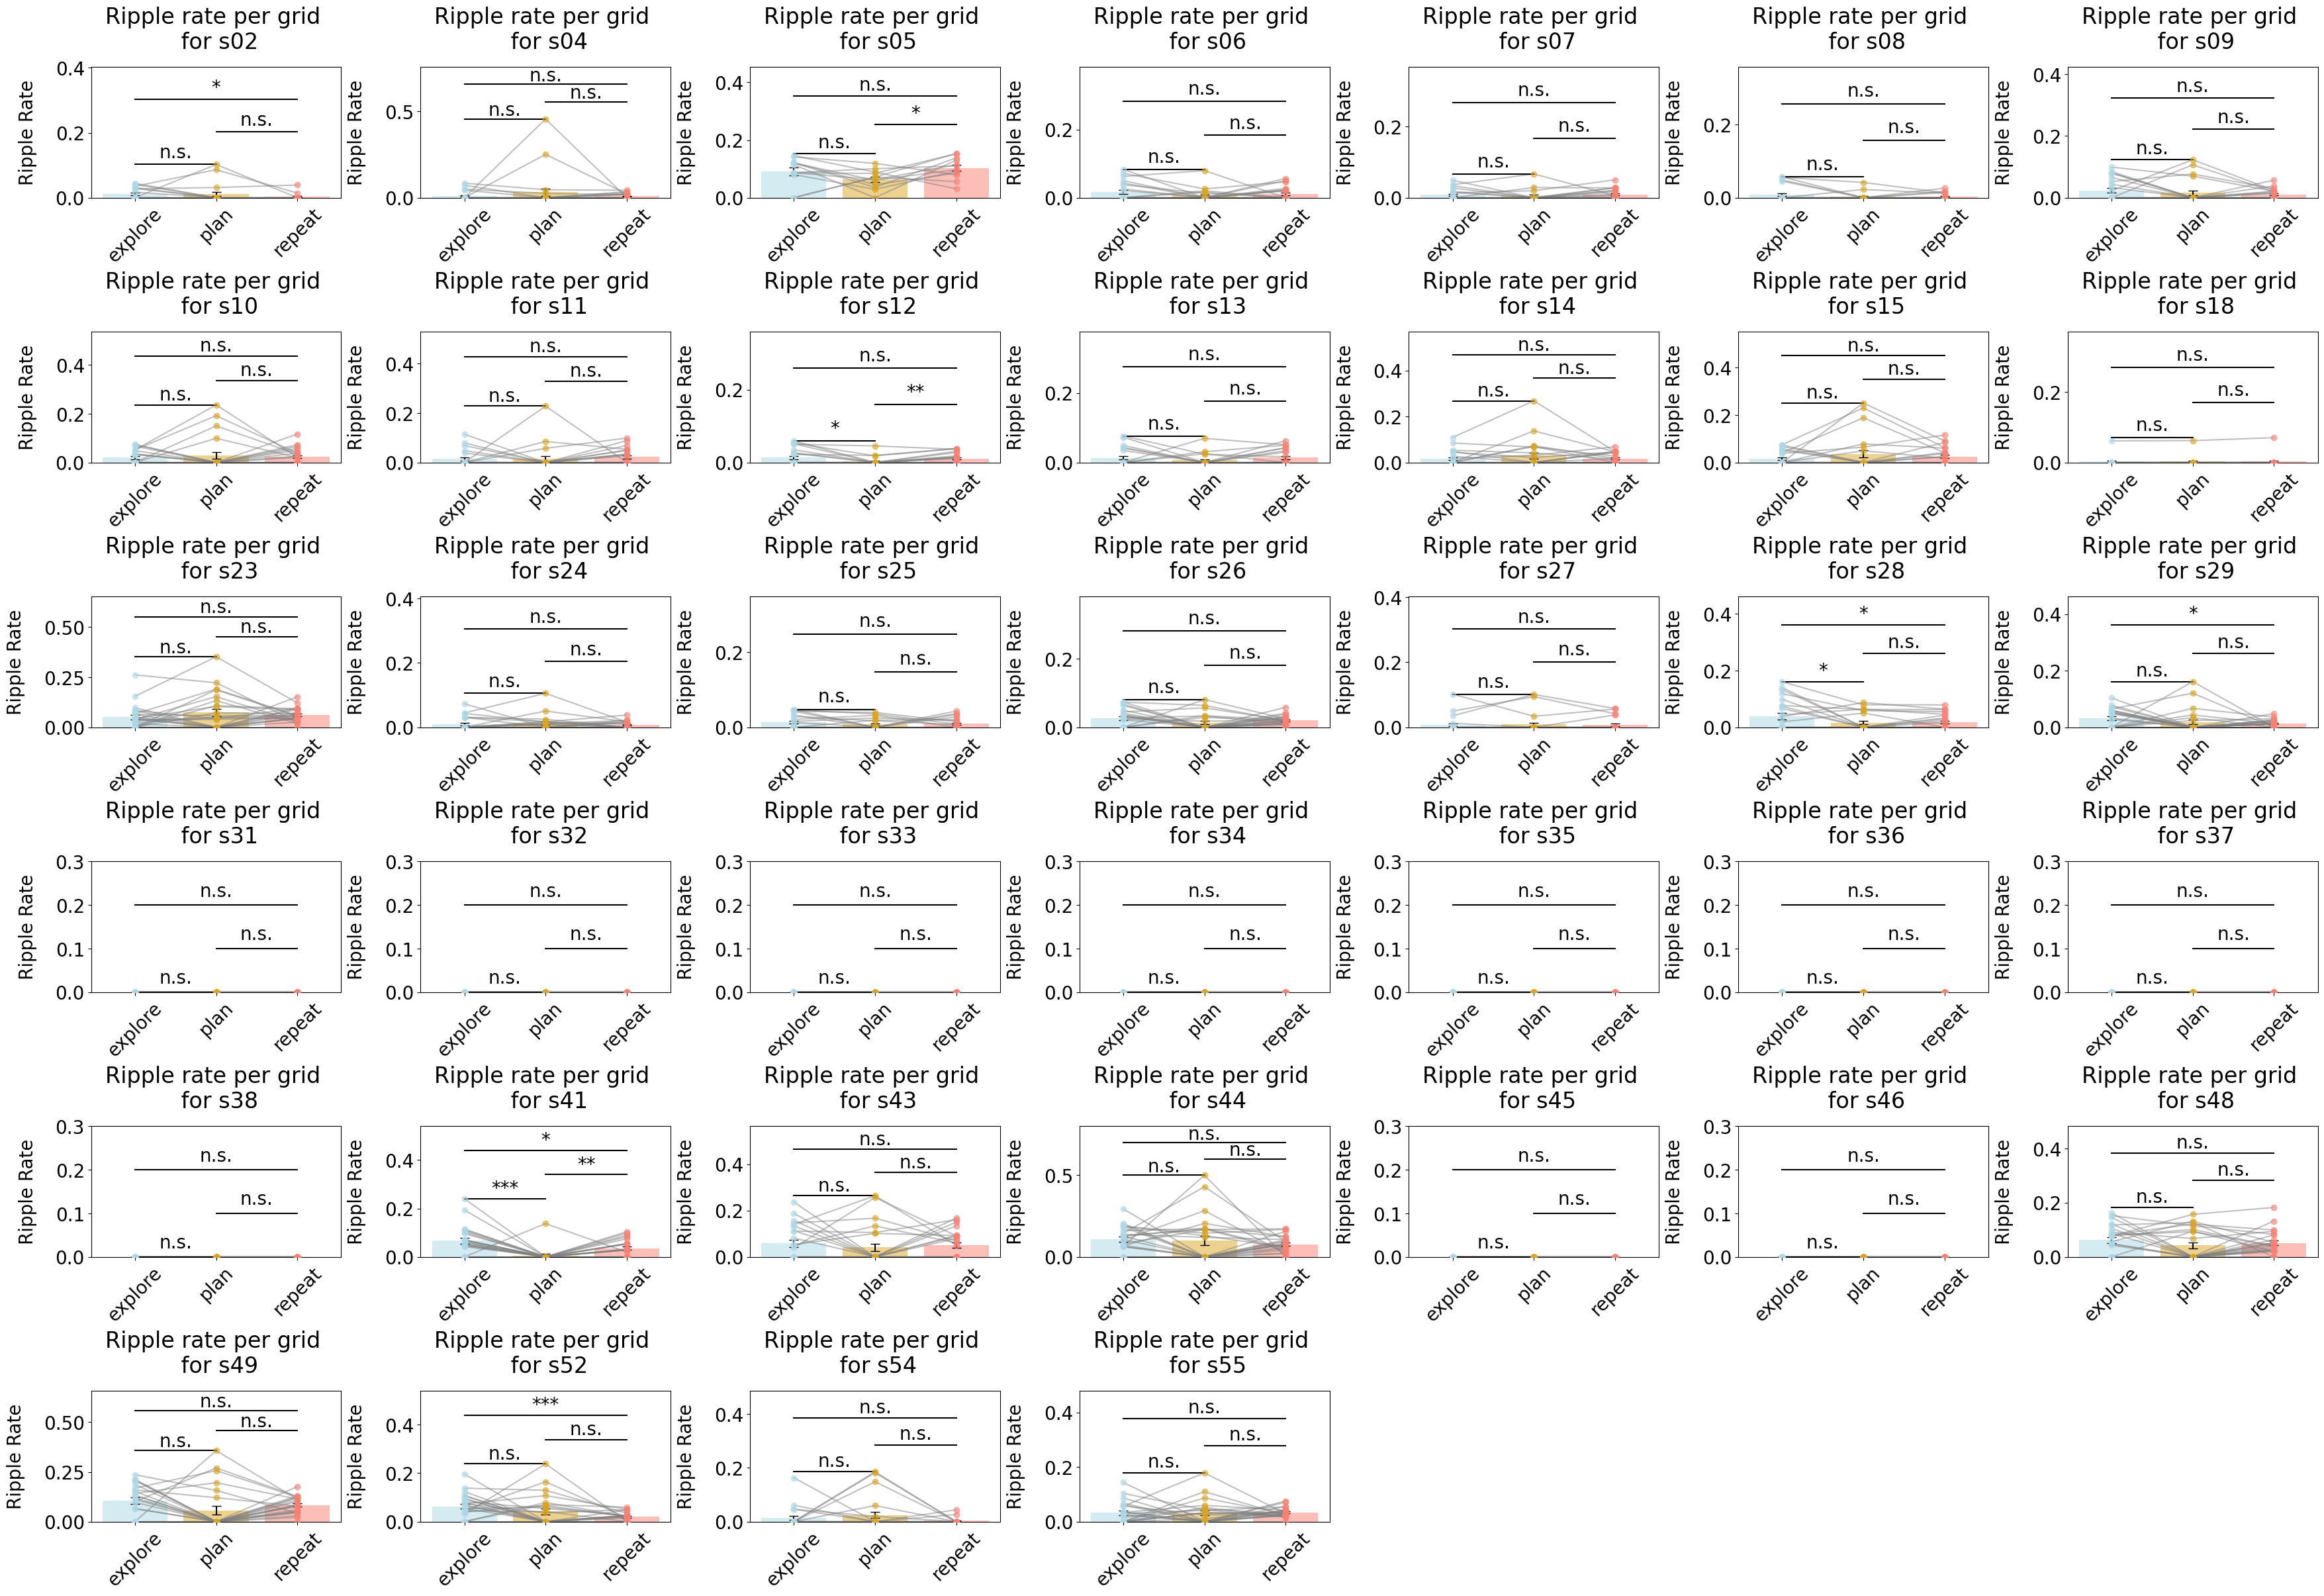

In [75]:
n_sessions = len(stats_df)
colors = ['lightblue','goldenrod', 'salmon']
plt.rcParams.update({'font.size': 20})

# dynamically compute rows and columns of subplots
n_rows, n_cols = math.ceil(n_sessions / math.ceil(n_sessions**0.5)), math.ceil(n_sessions**0.5)
# Create figure and axis
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), constrained_layout=True)
axes = axes.flatten()
    
for idx, row in stats_df.iterrows():
    ax = axes[idx]
    # Plot the bars
    ax.bar(row['means'].keys(), row['means'].values(), yerr=row['sems'].values(), capsize=5, color=colors, alpha=0.5)
    
    # Prepare plotting the scatter points for individual data points (i.e. ripple rates per task)
    data_curr_sesh = ripple_rates_df[ripple_rates_df['session']==row['session']]
    ripple_rate_curr_sesh_phase= []
    for idx_p, phase in enumerate(row['means'].keys()):
        ripple_rate_curr_sesh_phase.append(data_curr_sesh[data_curr_sesh['phase']==phase]['ripple_rate'].values)
        ax.scatter(np.ones(len(ripple_rate_curr_sesh_phase[idx_p]))*idx_p, ripple_rate_curr_sesh_phase[idx_p], color=colors[idx_p], alpha=0.6, zorder=3)
    
    # connect the ripple rate datapoint of each task across phases to demonstrate trajectory
    n_tasks = len(ripple_rate_curr_sesh_phase[0])
    for i_task in range(n_tasks):
        ax.plot([0, 1], [ripple_rate_curr_sesh_phase[0][i_task], ripple_rate_curr_sesh_phase[1][i_task]], color='gray', alpha=0.5, zorder=2)
        ax.plot([1, 2], [ripple_rate_curr_sesh_phase[1][i_task], ripple_rate_curr_sesh_phase[2][i_task]], color='gray', alpha=0.5, zorder=2)


    # for i_task, ripple_rate_in_task in enumerate(ripple_rate_curr_sesh_phase[idx]):
    #     ax.plot([0,1], [ripple_rate_curr_sesh_phase[0][i_task], ripple_rate_curr_sesh_phase[1][i_task]], color='gray', alpha=0.5, zorder=2)  # Connecting lines
    #     ax.plot([1,2], [ripple_rate_curr_sesh_phase[1][i_task], ripple_rate_curr_sesh_phase[2][i_task]], color='gray', alpha=0.5, zorder=2)  # Connecting lines
        
    

    # Compute max y for star placement
    all_vals = np.concatenate(ripple_rate_curr_sesh_phase)
    y_max = all_vals.max()
    
    # Draw line and star between plan and first_correct solve (plan)
    ax.plot([0, 1], [y_max]*2, color='black')
    ax.text(0.5, y_max + 0.02, p_to_star(row['t_explore_vs_plan_p']), ha='center')

    # Draw line and star between first_correct_rate and all_reps_rate
    ax.plot([1, 2], [y_max + 0.1]*2, color='black')
    ax.text(1.5, y_max + 0.12, p_to_star(row['t_plan_vs_repeat_p']), ha='center')

    # Draw line and star between find_ABCD_rate and all_reps_rate
    ax.plot([0, 2], [y_max + 0.2]*2, color='black')
    ax.text(1.0, y_max + 0.22, p_to_star(row['t_explore_vs_repeat_p']), ha='center')

    
    # final plot adjustments
    # Adjust y-limits to accommodate lines and stars
    ax.set_ylim(0, y_max + 0.3)

    # Adding labels
    ax.set_ylabel('Ripple Rate', labelpad=20)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['explore', 'plan', 'repeat'], rotation=45)
    ax.set_title(f"Ripple rate per grid \n for {row['session']}", pad=20)
    #ax.tight_layout()
    
# Turn off unused axes
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()
  

In [76]:
# ripple_rates_df contains trial-level data: session, phase, ripple_rate
model = smf.mixedlm("ripple_rate ~ phase", data=ripple_rates_df, groups="session")
result = model.fit()
print(result.summary())



          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: ripple_rate
No. Observations:  2775    Method:             REML       
No. Groups:        39      Scale:              0.0015     
Min. group size:   36      Log-Likelihood:     5042.0452  
Max. group size:   81      Converged:          Yes        
Mean group size:   71.2                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.024    0.004  5.914 0.000  0.016  0.032
phase[T.plan]   -0.005    0.002 -2.746 0.006 -0.008 -0.001
phase[T.repeat] -0.005    0.002 -2.987 0.003 -0.009 -0.002
session Var      0.001    0.004                           



/nfs/nhome/live/skuchenhoff/micromamba/envs/spyder_env/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/nfs/nhome/live/skuchenhoff/micromamba/envs/spyder_env/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/nfs/nhome/live/skuchenhoff/micromamba/envs/spyder_env/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


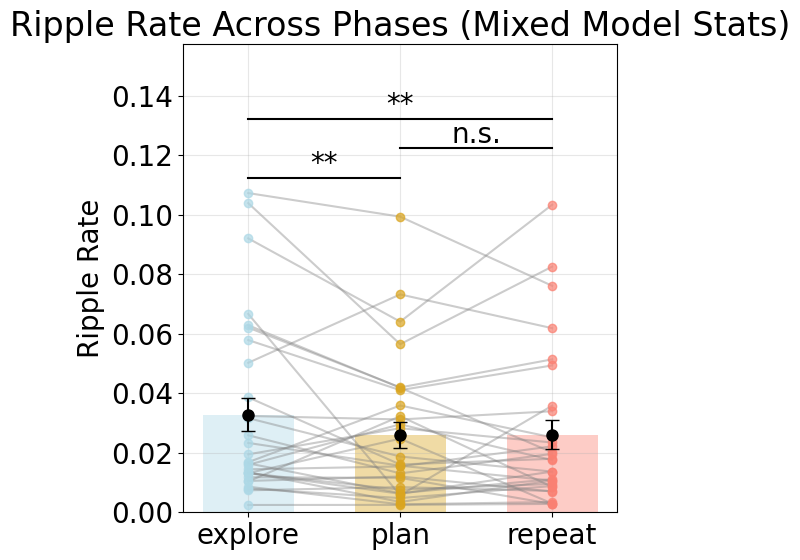

In [ ]:
colors = ['lightblue', 'goldenrod', 'salmon']
phases = ['explore', 'plan', 'repeat']

# Pivot to wide format: one row per session
pivot_df = ripple_rates_df.pivot_table(index='session', columns='phase', values='ripple_rate')

# 🔹 Filter out sessions with all-zero ripple rates
pivot_df = pivot_df[(pivot_df != 0).any(axis=1)]
valid_sessions = pivot_df.index
filtered_df = ripple_rates_df[ripple_rates_df['session'].isin(valid_sessions)]

# 🔹 Fit mixed-effects model with explore as baseline
model1 = smf.mixedlm("ripple_rate ~ phase", data=filtered_df, groups="session")
res1 = model1.fit()

# 🔹 Refit with 'plan' as baseline to get plan vs repeat
df_plan_ref = filtered_df.copy()
df_plan_ref['phase'] = pd.Categorical(df_plan_ref['phase'], categories=['plan', 'explore', 'repeat'], ordered=True)
model2 = smf.mixedlm("ripple_rate ~ phase", data=df_plan_ref, groups="session")
res2 = model2.fit()

# 🔹 Get p-values from model
p_ep_plan = res1.pvalues['phase[T.plan]']
p_ep_repeat = res1.pvalues['phase[T.repeat]']
p_plan_repeat = res2.pvalues['phase[T.repeat]']

# Plotting
x = np.arange(len(phases))  # [0, 1, 2]
plt.figure(figsize=(6, 6))

# Connect lines per session
for _, row in pivot_df.iterrows():
    plt.plot(x, row.values, color='gray', alpha=0.4, zorder=1)

# Scatter individual session points
for i, phase in enumerate(phases):
    y = pivot_df[phase].values
    plt.scatter([i] * len(y), y, color=colors[i], zorder=2, alpha=0.7)

# Transparent bars for mean
means = pivot_df.mean()
sems = pivot_df.sem()
for i, phase in enumerate(phases):
    plt.bar(i, means[phase], width=0.6, color=colors[i], alpha=0.4, zorder=0)

# Mean ± SEM error bars
plt.errorbar(x, means, yerr=sems, fmt='o', color='black', capsize=5, markersize=8, zorder=3)

# Axes & labels
plt.xticks(x, phases)
plt.ylabel('Ripple Rate')
plt.title('Ripple Rate Across Phases (Mixed Model Stats)')
plt.grid(alpha=0.3)

# Significance stars from model p-values
def p_to_star(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'n.s.'

y_max = pivot_df.max().max()

plt.plot([0, 1], [y_max + 0.005] * 2, color='black')
plt.text(0.5, y_max + 0.007, p_to_star(p_ep_plan), ha='center')

plt.plot([1, 2], [y_max + 0.015] * 2, color='black')
plt.text(1.5, y_max + 0.017, p_to_star(p_plan_repeat), ha='center')

plt.plot([0, 2], [y_max + 0.025] * 2, color='black')
plt.text(1.0, y_max + 0.027, p_to_star(p_ep_repeat), ha='center')

plt.ylim(0, y_max + 0.05)
plt.tight_layout()
plt.show()


In [ ]:
# Create output directory with today's date
today = datetime.today().strftime('%Y-%m-%d')
out_dir = f"./figures/{today}"
os.makedirs(out_dir, exist_ok=True)

# File paths
png_path = os.path.join(out_dir, "ripple_rate_summary.png")
svg_path = os.path.join(out_dir, "ripple_rate_summary.svg")

# Save figures
plt.savefig(png_path, dpi=300)       # High-res raster image
plt.savefig(svg_path, format='svg')  # Vector format

print(f"Figure saved to:\n- {png_path}\n- {svg_path}")



     session grid_no    phase  ripple_count  duration  ripple_rate
1470     s31       1  explore             0     63.33          0.0
1471     s31       1     plan             0     26.16          0.0
1472     s31       1   repeat             0     64.83          0.0
1473     s31       2  explore             0     24.86          0.0
1474     s31       2     plan             0     15.30          0.0
...      ...     ...      ...           ...       ...          ...
2407     s46      23     plan             0      5.50          0.0
2408     s46      23   repeat             0     42.00          0.0
2409     s46      24  explore             0     23.30          0.0
2410     s46      24     plan             0      5.80          0.0
2411     s46      24   repeat             0     39.60          0.0

[720 rows x 6 columns]


In [63]:
# compute stats collapsed across all sessions.
# Group all by phase, ignoring session
collapsed_summary = ripple_rates_df.groupby('phase')['ripple_rate'].agg(['mean', 'sem']).reset_index()

# Pairwise t-tests (all data)
explore_rates = ripple_rates_df[ripple_rates_df['phase'] == 'explore']['ripple_rate']
plan_rates = ripple_rates_df[ripple_rates_df['phase'] == 'plan']['ripple_rate']
repeat_rates = ripple_rates_df[ripple_rates_df['phase'] == 'repeat']['ripple_rate']

t_explore_plan = stats.ttest_rel(explore_rates, plan_rates)
t_plan_repeat = stats.ttest_rel(plan_rates, repeat_rates)
t_explore_repeat = stats.ttest_rel(explore_rates, repeat_rates)

collapsed_stats = {
    'means': collapsed_summary.set_index('phase')['mean'].to_dict(),
    'sems': collapsed_summary.set_index('phase')['sem'].to_dict(),
    't_explore_vs_plan_p': t_explore_plan.pvalue,
    't_plan_vs_repeat_p': t_plan_repeat.pvalue,
    't_explore_vs_repeat_p': t_explore_repeat.pvalue
}

stats_collapsed_seshs_df = pd.DataFrame(collapsed_stats)
stats_collapsed_seshs_df.head()

from pprint import pprint
print("\nCollapsed stats across sessions:")
pprint(collapsed_stats)


Collapsed stats across sessions:
{'means': {'explore': 0.023682264841163793,
           'plan': 0.018804564457195642,
           'repeat': 0.018376437871684526},
 'sems': {'explore': 0.0014807548805728147,
          'plan': 0.0017806987753121277,
          'repeat': 0.0010691104094262978},
 't_explore_vs_plan_p': 0.011497418704543396,
 't_explore_vs_repeat_p': 1.497927320015899e-05,
 't_plan_vs_repeat_p': 0.8020258939765467}


In [ ]:
# ripple plotting function.
# requires the raw snippet, the event timings, and the power.


plot_ripple(freq_to_plot, title, downsampled_data, event, min_length_ripple, filtered_cropped_vhgamma_np, power_dict, repeat, freq_bands_keys, y_label_power, for_publication = False):

downsampled_data = load_snippet(snippet_name)
    
x = np.arange(-freq_to_plot, freq_to_plot) * 2
    

plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(2)
# here, plot only 40ms before and after the event
no_of_samples = 0.03*freq_to_plot
x = np.arange(-no_of_samples, no_of_samples) * 2
freq_to_plot = int(no_of_samples)


# only plot half of this:
# freq_to_plot = freq_to_plot/2
# Create x-values from 5500 to 9500
# x = np.linspace(event[0]-freq_to_plot, event[0]+freq_to_plot-1, freq_to_plot*2)


# the fifth subplot is the overall power spectrum
# power_to_plot_all = np.stack(power_all[freq_bands_keys[0]][event[-1], :, event[0]-sampling_freq:event[0]+sampling_freq], power_all[freq_bands_keys[1]][event[-1], :, event[0]-sampling_freq:event[0]+sampling_freq], power_all[freq_bands_keys[2]][event[-1], :, event[0]-sampling_freq:event[0]+sampling_freq])
power_to_plot_all = np.vstack((power_dict[f"{repeat}_stepwise"][freq_bands_keys[0]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot], power_dict[f"{repeat}_stepwise"][freq_bands_keys[1]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot]))
power_to_plot_all = np.vstack((power_to_plot_all, power_dict[f"{repeat}_stepwise"][freq_bands_keys[2]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot]))
power_to_plot_all = np.vstack((power_to_plot_all, power_dict[f"{repeat}_stepwise"][freq_bands_keys[3]][event[-1], :, event[0]-freq_to_plot:event[0]+freq_to_plot]))
y_ticks = [5, 25, 45, 65, power_to_plot_all.shape[0] - 1]  # 5, 25, 45, 65 and the max value (y-axis max)


axs[1].set_title('downsampled raw LFP', pad=20)
axs[1].set_xlabel('Time (ms)')
# set a few x-ticks around the ripple in 20ms resolution. 
axs[1].plot(x, downsampled_data[event[0]-freq_to_plot:event[0]+freq_to_plot, event[-1]], linewidth = 2, color='black')
axs[1].set_xticks(np.arange(0-3*min_length_ripple, 4*min_length_ripple, 1.5*min_length_ripple))  # Set x-ticks from 0 to 10 with a step of 0.5

axs[0].imshow(power_to_plot_all, aspect='auto', origin='lower')
axs[0].set_xticks([])
# Setting the yticks and the labels
axs[0].set_title('power spectrum', pad = 20)
axs[0].set_yticks(y_ticks[:-1])  # Add the desired tick positions except the last one
axs[0].set_yticks([y_ticks[-1]], minor=True)  # Add the max position as a minor tick
axs[0].set_yticklabels(y_label_power)  # Add the desired tick labels